In [3]:
#Loading required libraries:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage import color
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)

In [4]:
#Data Preprocessing:
def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

# Transposing the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Train", X_train.shape)
print("Test", X_test.shape)
print('')

total_images = X_train.shape[0] + X_test.shape[0]

print("Total Images:", total_images)


# Normalizing pixel values
X_train, X_test = X_train / 255.0, X_test / 255.0

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)
Train (73257, 32, 32, 3)
Test (26032, 32, 32, 3)

Total Images: 99289


In [5]:
#Function to plot images
def plot_images(img, labels, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols) 
    for i, ax in enumerate(axes.flat):  
        if img[i].shape == (32, 32, 3): 
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0]) 
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i]) 

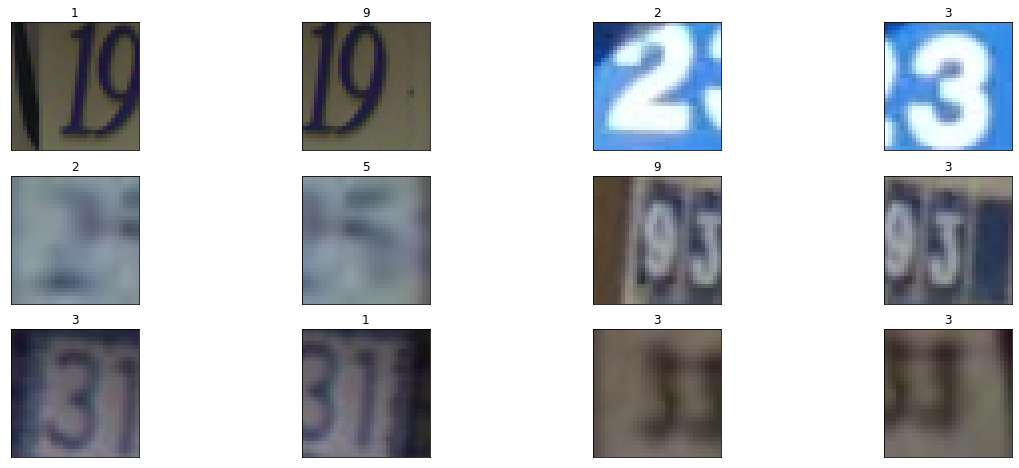

In [6]:
# Plots some training set images
plot_images(X_train, y_train, 3, 4)

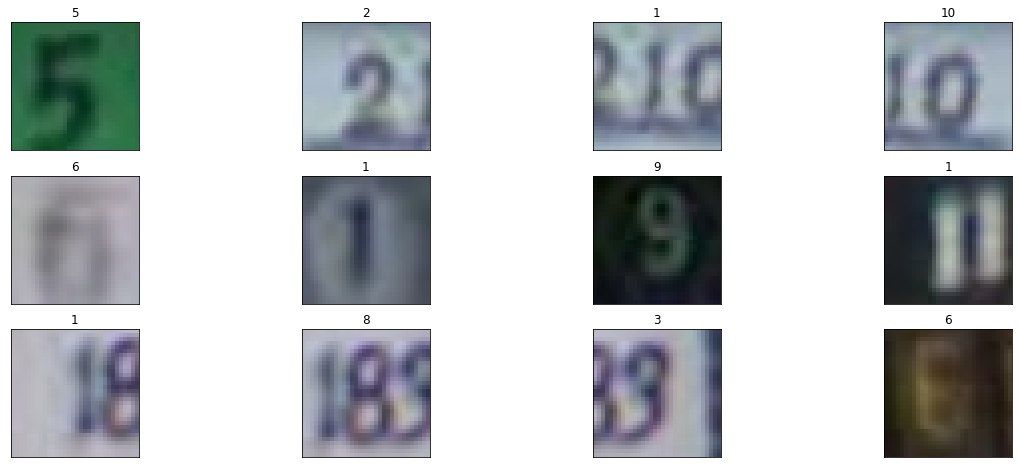

In [7]:
# Plots some test set images
plot_images(X_test, y_test, 3, 4)

In [8]:
#Changing label 10 to label 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [9]:
#CNN Implementation:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow.keras import layers, models

from tensorflow.keras.callbacks import TensorBoard
tb = TensorBoard(log_dir='./logs', histogram_freq=10, write_graph=True, write_images=True)

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min')

from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
#Model 1 (Using Adaptive Optimization):
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.9274 - accuracy: 0.7011 - val_loss: 0.5723 - val_accuracy: 0.8304
Epoch 2/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.4464 - accuracy: 0.8688 - val_loss: 0.4607 - val_accuracy: 0.8673
Epoch 3/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.3733 - accuracy: 0.8895 - val_loss: 0.4150 - val_accuracy: 0.8809
Epoch 4/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.3302 - accuracy: 0.9025 - val_loss: 0.3829 - val_accuracy: 0.8869
Epoch 5/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.3008 - accuracy: 0.9109 - val_loss: 0.3828 - val_accuracy: 0.8883
Epoch 6/10
2290/2290 [==============================] - 19s 8ms/step - loss: 0.2759 - accuracy: 0.9182 - val_loss: 0.3865 - val_accuracy: 0.8925
Epoch 7/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.2571 - accuracy: 0.9236 - val_loss: 0.4063 - val_ac

814/814 - 3s - loss: 0.3846 - accuracy: 0.8961


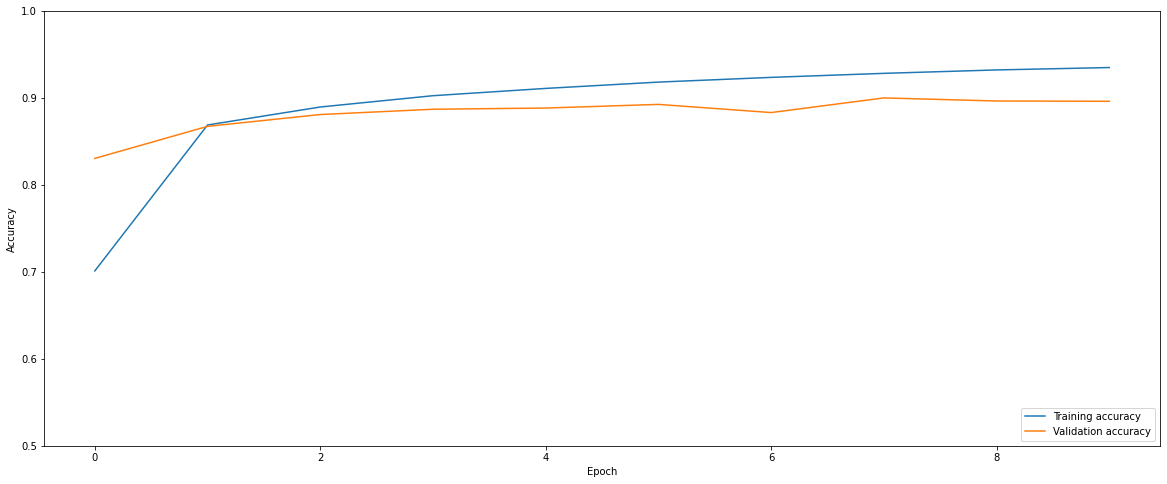

In [13]:
# Training vs validation accuracy:

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [14]:
print(test_acc)

0.8960894346237183


Model 1 accuracy: 89%

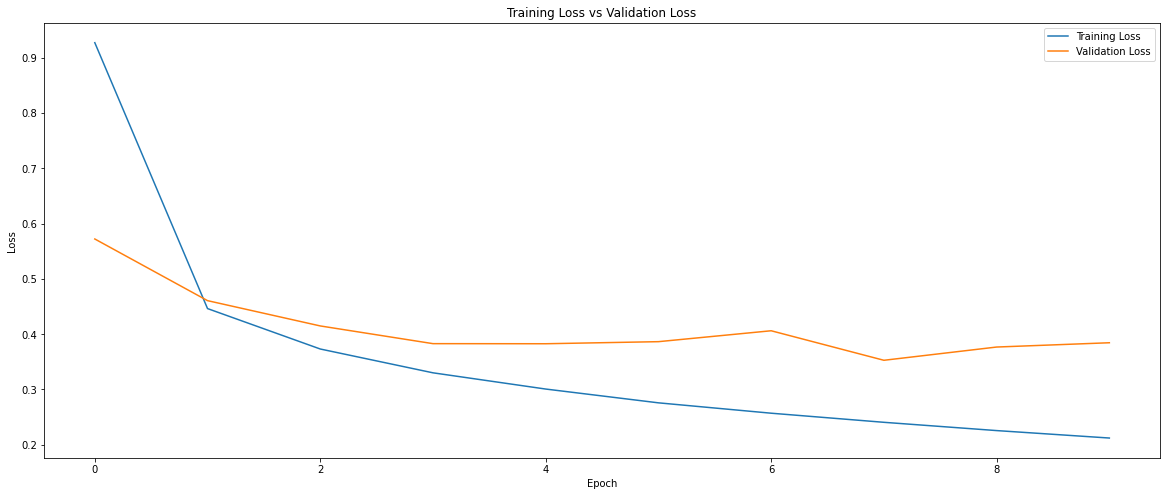

In [15]:
# Training vs validation loss:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [16]:
#Model 2 - Using Stochastic Gradient Descent:
modelSGD = models.Sequential()
modelSGD.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelSGD.add(layers.MaxPooling2D((2, 2)))
modelSGD.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelSGD.add(layers.MaxPooling2D((2, 2)))
modelSGD.add(layers.Conv2D(64, (3, 3), activation='relu'))

modelSGD.add(layers.Flatten())
modelSGD.add(layers.Dense(64, activation='relu'))
modelSGD.add(layers.Dense(10, activation='softmax'))

In [19]:
modelSGD.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historySGD = modelSGD.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
2290/2290 [==============================] - 18s 8ms/step - loss: 1.4322 - accuracy: 0.5294 - val_loss: 0.8001 - val_accuracy: 0.7813
Epoch 2/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.6595 - accuracy: 0.8098 - val_loss: 0.6289 - val_accuracy: 0.8258
Epoch 3/10
2290/2290 [==============================] - 17s 8ms/step - loss: 0.5402 - accuracy: 0.8440 - val_loss: 0.5711 - val_accuracy: 0.8409
Epoch 4/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.4799 - accuracy: 0.8605 - val_loss: 0.5210 - val_accuracy: 0.8526
Epoch 5/10
2290/2290 [==============================] - 17s 8ms/step - loss: 0.4375 - accuracy: 0.8726 - val_loss: 0.5058 - val_accuracy: 0.8534
Epoch 6/10
2290/2290 [==============================] - 19s 8ms/step - loss: 0.4046 - accuracy: 0.8808 - val_loss: 0.5161 - val_accuracy: 0.8514
Epoch 7/10
2290/2290 [==============================] - 18s 8ms/step - loss: 0.3786 - accuracy: 0.8886 - val_loss: 0.4450 - val_ac

814/814 - 3s - loss: 0.4207 - accuracy: 0.8816


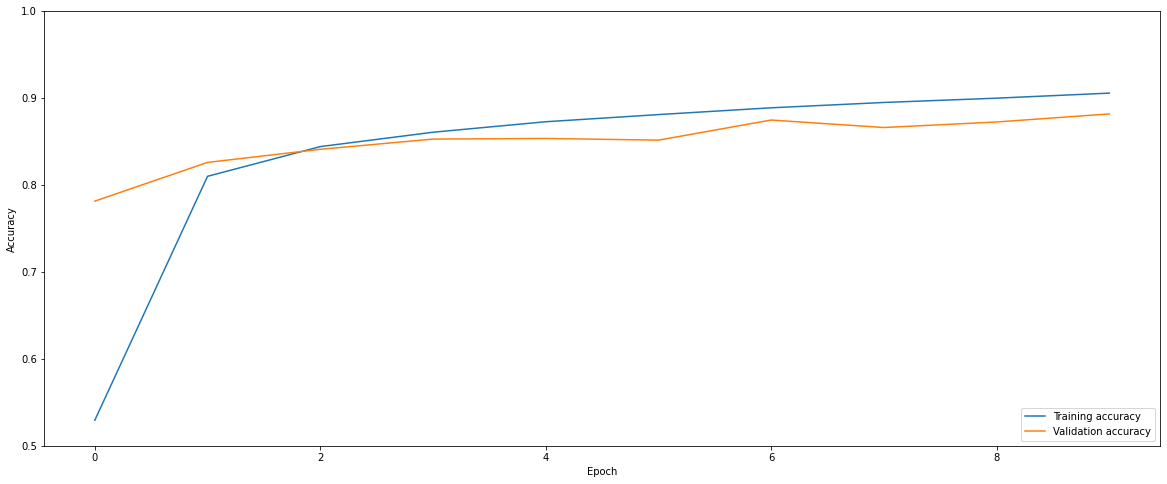

In [20]:
# Training vs validation accuracy:

plt.plot(historySGD.history['accuracy'], label='Training accuracy')
plt.plot(historySGD.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelSGD.evaluate(X_test,  y_test, verbose=2)

In [21]:
print(test_acc)

0.8815688490867615


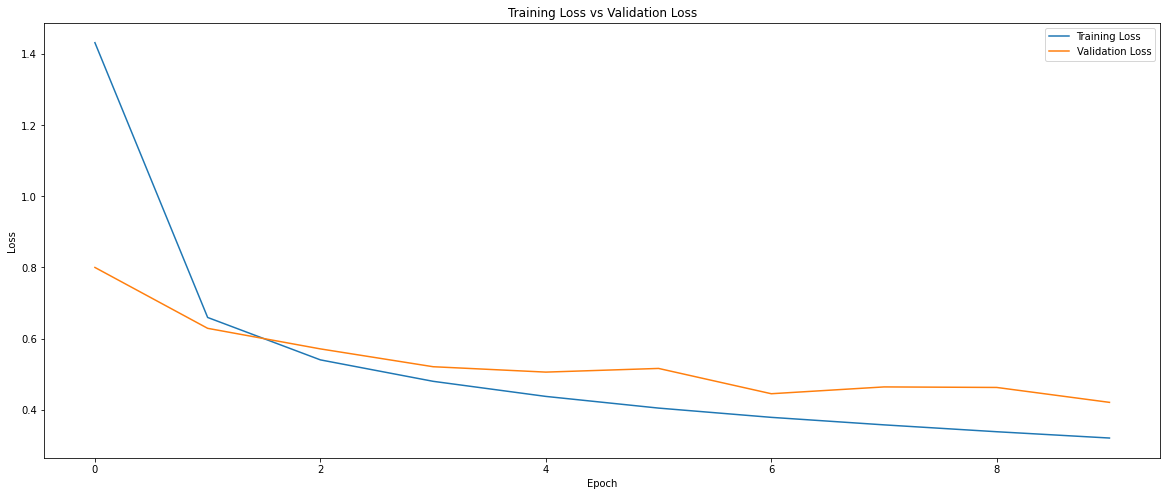

In [22]:
# Training vs validation loss:

plt.plot(historySGD.history['loss'], label='Training Loss')
plt.plot(historySGD.history['val_loss'], label = 'Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [24]:
#Model 3 - Using Dropout as a regularization method:
#We see SGD caught up to the speed of Adam from above models (also both the optimizers performed closely)
#Using Adam for accelarated training
modelDropout = models.Sequential()

modelDropout.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelDropout.add(layers.Conv2D(64, (3, 3), activation='relu'))

modelDropout.add(layers.MaxPooling2D((2, 2)))

modelDropout.add(layers.Dropout(0.25))

modelDropout.add(layers.Flatten())

modelDropout.add(layers.Dense(128, activation='relu'))

modelDropout.add(layers.Dropout(0.5))

modelDropout.add(layers.Dense(10, activation='softmax'))

modelDropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historyDropout = modelDropout.fit(X_train, y_train, epochs=10, batch_size = 256, 
                    validation_data=(X_test, y_test))

Epoch 1/10
287/287 [==============================] - 12s 41ms/step - loss: 1.5365 - accuracy: 0.4822 - val_loss: 0.7882 - val_accuracy: 0.7797
Epoch 2/10
287/287 [==============================] - 12s 41ms/step - loss: 0.8542 - accuracy: 0.7344 - val_loss: 0.6556 - val_accuracy: 0.8088
Epoch 3/10
287/287 [==============================] - 12s 40ms/step - loss: 0.7374 - accuracy: 0.7702 - val_loss: 0.5916 - val_accuracy: 0.8335
Epoch 4/10
287/287 [==============================] - 12s 41ms/step - loss: 0.6816 - accuracy: 0.7847 - val_loss: 0.6020 - val_accuracy: 0.8236
Epoch 5/10
287/287 [==============================] - 12s 41ms/step - loss: 0.6452 - accuracy: 0.7989 - val_loss: 0.5305 - val_accuracy: 0.8466
Epoch 6/10
287/287 [==============================] - 12s 40ms/step - loss: 0.6127 - accuracy: 0.8090 - val_loss: 0.5187 - val_accuracy: 0.8496
Epoch 7/10
287/287 [==============================] - 12s 40ms/step - loss: 0.5857 - accuracy: 0.8165 - val_loss: 0.4921 - val_accuracy:

814/814 - 4s - loss: 0.4587 - accuracy: 0.8657


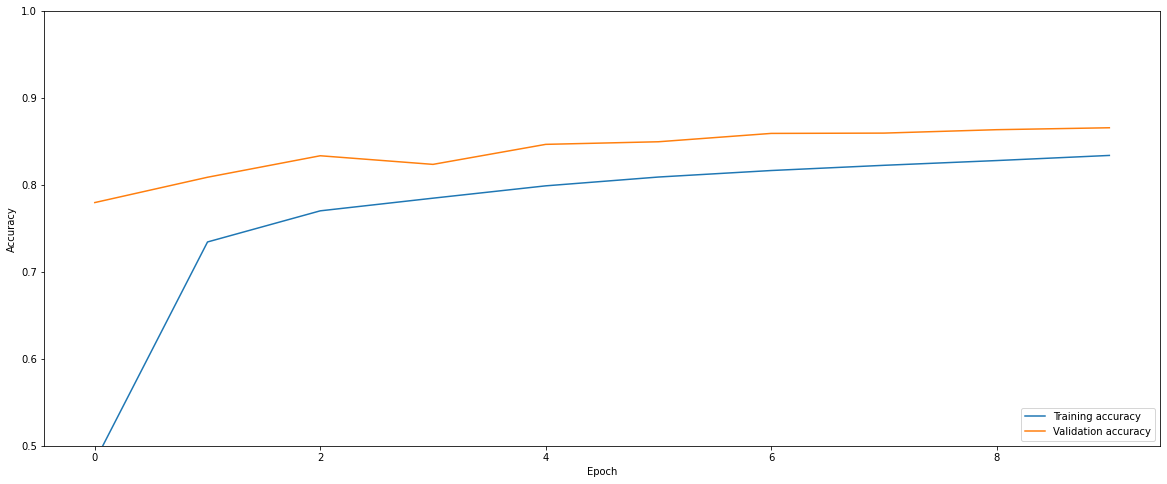

In [25]:
# Training vs validation accuracy:

plt.plot(historyDropout.history['accuracy'], label='Training accuracy')
plt.plot(historyDropout.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelDropout.evaluate(X_test,  y_test, verbose=2)

In [26]:
print(test_acc)

0.8656653165817261


In [27]:
from tensorflow.keras import regularizers

In [31]:
#Model 4 - Using L2 Regularizer (Ridge)
modelRidge = models.Sequential()

modelRidge.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
modelRidge.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))

modelRidge.add(layers.MaxPooling2D((2, 2)))

modelRidge.add(layers.Flatten())

modelRidge.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))

modelRidge.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))

modelRidge.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historyRidge = modelRidge.fit(X_train, y_train, epochs=10, batch_size = 256, 
                    validation_data=(X_test, y_test))

Epoch 1/10
287/287 [==============================] - 12s 40ms/step - loss: 2.1817 - accuracy: 0.4084 - val_loss: 1.7162 - val_accuracy: 0.6008
Epoch 2/10
287/287 [==============================] - 11s 39ms/step - loss: 1.4823 - accuracy: 0.7050 - val_loss: 1.3880 - val_accuracy: 0.7416
Epoch 3/10
287/287 [==============================] - 11s 40ms/step - loss: 1.2698 - accuracy: 0.7870 - val_loss: 1.2648 - val_accuracy: 0.7934
Epoch 4/10
287/287 [==============================] - 12s 40ms/step - loss: 1.2007 - accuracy: 0.8090 - val_loss: 1.2105 - val_accuracy: 0.8082
Epoch 5/10
287/287 [==============================] - 11s 39ms/step - loss: 1.1758 - accuracy: 0.8171 - val_loss: 1.2279 - val_accuracy: 0.8072
Epoch 6/10
287/287 [==============================] - 11s 40ms/step - loss: 1.1522 - accuracy: 0.8226 - val_loss: 1.2365 - val_accuracy: 0.7882
Epoch 7/10
287/287 [==============================] - 11s 39ms/step - loss: 1.1445 - accuracy: 0.8249 - val_loss: 1.2021 - val_accuracy:

814/814 - 4s - loss: 1.1797 - accuracy: 0.8143


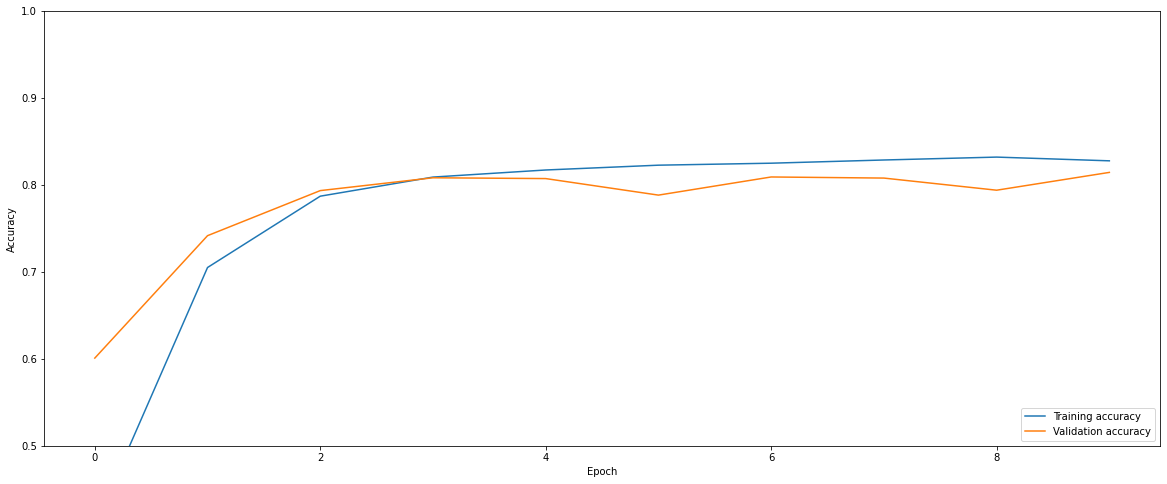

In [33]:
# Training vs validation accuracy:

plt.plot(historyRidge.history['accuracy'], label='Training accuracy')
plt.plot(historyRidge.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelRidge.evaluate(X_test,  y_test, verbose=2)

In [35]:
print(test_acc)

0.8143438696861267


In [36]:
#Model 5 - Using Batch Normalization:
#Using Dropout as regularization method as it is better than Ridge (based on the above 2 models modelDropout, modelRidge)
modelBatch = models.Sequential()

modelBatch.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelBatch.add(layers.Conv2D(32, (3, 3), activation='relu'))
                             
modelBatch.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelBatch.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelBatch.add(layers.Conv2D(64, (3, 3), activation='relu'))

modelBatch.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
modelBatch.add(layers.Dropout(0.2))
modelBatch.add(layers.Flatten())

modelBatch.add(layers.BatchNormalization(epsilon=0.001, axis=-1, momentum=0.99, weights=None, beta_initializer='zero',  gamma_regularizer=None, beta_regularizer=None))
modelBatch.add(layers.Activation('relu'))
modelBatch.add(layers.BatchNormalization(epsilon=0.001, axis=-1, momentum=0.99, weights=None, beta_initializer='zero',  gamma_regularizer=None, beta_regularizer=None))
modelBatch.add(layers.Activation('relu'))

modelBatch.add(layers.Dense(1024))
modelBatch.add(layers.Activation('relu'))
modelBatch.add(layers.Dropout(0.2))
modelBatch.add(layers.Dense(10))
modelBatch.add(layers.Activation('softmax'))
    
modelBatch.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

historyBatch = modelBatch.fit(X_train, y_train,epochs=10, batch_size = 256, 
                    validation_data=(X_test, y_test))

Epoch 1/10
287/287 [==============================] - 14s 48ms/step - loss: 0.7926 - accuracy: 0.7533 - val_loss: 2.1568 - val_accuracy: 0.4009
Epoch 2/10
287/287 [==============================] - 13s 46ms/step - loss: 0.3879 - accuracy: 0.8835 - val_loss: 0.7573 - val_accuracy: 0.8559
Epoch 3/10
287/287 [==============================] - 13s 47ms/step - loss: 0.3120 - accuracy: 0.9053 - val_loss: 0.4039 - val_accuracy: 0.8891
Epoch 4/10
287/287 [==============================] - 13s 47ms/step - loss: 0.2685 - accuracy: 0.9191 - val_loss: 0.3668 - val_accuracy: 0.8934
Epoch 5/10
287/287 [==============================] - 13s 47ms/step - loss: 0.2314 - accuracy: 0.9308 - val_loss: 0.3360 - val_accuracy: 0.9054
Epoch 6/10
287/287 [==============================] - 13s 46ms/step - loss: 0.2065 - accuracy: 0.9370 - val_loss: 0.4653 - val_accuracy: 0.8819
Epoch 7/10
287/287 [==============================] - 13s 46ms/step - loss: 0.1818 - accuracy: 0.9451 - val_loss: 0.2850 - val_accuracy:

814/814 - 4s - loss: 0.2991 - accuracy: 0.9178


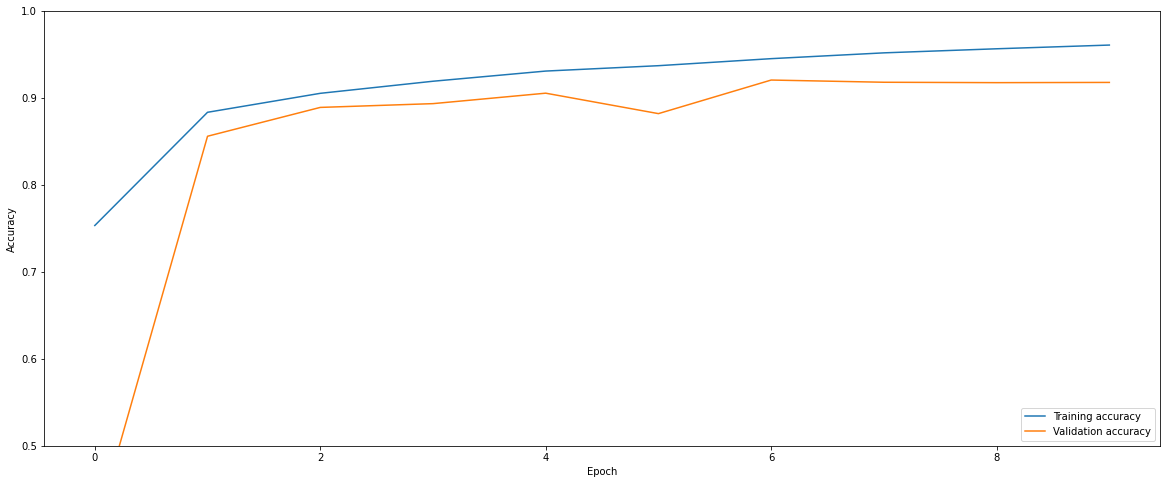

In [37]:
# Training vs validation accuracy:

plt.plot(historyBatch.history['accuracy'], label='Training accuracy')
plt.plot(historyBatch.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelBatch.evaluate(X_test,  y_test, verbose=2)

In [38]:
print(test_acc)

0.9177935123443604


In [ ]:
#Model 6 - Using Batch Normalization along with Real time Data Augmentation:
#Using Dropout, Adam
modelBatch_DataAug = models.Sequential()

modelBatch_DataAug.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelBatch_DataAug.add(layers.Conv2D(32, (3, 3), activation='relu'))
                             
modelBatch_DataAug.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelBatch_DataAug.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelBatch_DataAug.add(layers.Conv2D(64, (3, 3), activation='relu'))

modelBatch_DataAug.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
modelBatch_DataAug.add(layers.Dropout(0.2))
modelBatch_DataAug.add(layers.Flatten())

modelBatch_DataAug.add(layers.BatchNormalization(epsilon=0.001, axis=-1, momentum=0.99, weights=None, beta_initializer='zero',  gamma_regularizer=None, beta_regularizer=None))
modelBatch_DataAug.add(layers.Activation('relu'))
modelBatch_DataAug.add(layers.BatchNormalization(epsilon=0.001, axis=-1, momentum=0.99, weights=None, beta_initializer='zero',  gamma_regularizer=None, beta_regularizer=None))
modelBatch_DataAug.add(layers.Activation('relu'))

modelBatch_DataAug.add(layers.Dense(1024))
modelBatch_DataAug.add(layers.Activation('relu'))
modelBatch_DataAug.add(layers.Dropout(0.2))
modelBatch_DataAug.add(layers.Dense(10))
modelBatch_DataAug.add(layers.Activation('softmax'))
    
modelBatch_DataAug.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


datagen = ImageDataGenerator(featurewise_center=False,samplewise_center=False,featurewise_std_normalization=False,
                              samplewise_std_normalization=False,zca_whitening=False,rotation_range=5,width_shift_range=0.1,
                              height_shift_range=0.1,horizontal_flip=False,vertical_flip=False)

datagen.fit(X_train)

# Fitting the model on the batches generated by datagen.flow():
historyBatch_DataAug = modelBatch_DataAug.fit_generator(datagen.flow(X_train, y_train,batch_size=256), steps_per_epoch=None, epochs=40,
                                                        validation_data=(X_test, y_test))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
287/287 [==============================] - 50s 173ms/step - loss: 1.2140 - accuracy: 0.6083 - val_loss: 2.2300 - val_accuracy: 0.1968
Epoch 2/40
287/287 [==============================] - 49s 172ms/step - loss: 0.6393 - accuracy: 0.7987 - val_loss: 0.7110 - val_accuracy: 0.8090
Epoch 3/40
287/287 [==============================] - 50s 173ms/step - loss: 0.5181 - accuracy: 0.8383 - val_loss: 0.3889 - val_accuracy: 0.8896
Epoch 4/40
287/287 [==============================] - 49s 172ms/step - loss: 0.4619 - accuracy: 0.8579 - val_loss: 0.4554 - val_accuracy: 0.8627
Epoch 5/40
287/287 [==============================] - 49s 172ms/step - loss: 0.4234 - accuracy: 0.8702 - val_loss: 0.3009 - val_accuracy: 0.9138
Epoch 6/40
287/287 [==============================] - 49s 171ms/step - loss: 0.3875 - accuracy: 0.8809 - val_loss: 0.3054 - val_accuracy: 0.9155
Epoch 7/40
287/287 [==============================] - 